<!-- 
 * @file        9_vehicle_dynamics.ipynb
 * @brief       Vehicle Dynamics and Longitudinal/Lateral Control
 * 
 * @authors     Jaehwan Lee (idljh5529@gmail.com)      
 *
 * @date        2025-08-14 Released by AI Lab, Hanyang University
 * 
-->

# 9. Vehicle Dynamics & 종횡방향 제어
이번 실습에서는 차량의 동역학 모델을 구현하고 종방향 및 횡방향 제어 알고리즘을 학습합니다.

## 실습 목표
1. **차량 동역학 모델 구현**: 종방향 dynamic 모델과 횡방향 kinematic/dynamic 모델 구현
2. **속도 기반 모델 스위칭**: 속도에 따른 횡방향 모델 자동 전환 (kinematic ↔ dynamic)
3. **종횡방향 제어 알고리즘**: Pure Pursuit, Stanley 제어 및 PID 속도 제어 구현
4. **경로 추종 시뮬레이션**: 통합 제어 시스템을 통한 실시간 경로 추종

## 다루는 차량 동역학 모델
- **종방향 Dynamic Model**: 모터 토크, 공기저항, 구름저항 고려
- **횡방향 Kinematic Model**: 저속 주행 시 (v < 5 m/s)
- **횡방향 Dynamic Model**: 고속 주행 시 (v ≥ 5 m/s)

## 실습 구성
1. 차량 동역학 모델 개별 구현 및 검증
2. 속도별 횡방향 모델 비교 분석
3. 종횡방향 제어 알고리즘 구현
4. 통합 경로 추종 시뮬레이션

In [17]:
# 외부에 정의된 파이썬 모듈(.py 파일)을 수정할 때마다 매번 커널을 재시작하지 않아도 변경 사항이 자동으로 반영되도록 설정
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# 필요한 라이브러리 임포트
import sys
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("라이브러리 임포트 완료!")
print("Python 버전:", sys.version)
print("NumPy 버전:", np.__version__)
print("Matplotlib 버전:", plt.matplotlib.__version__)


라이브러리 임포트 완료!
Python 버전: 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]
NumPy 버전: 2.2.6
Matplotlib 버전: 3.10.5


## 1. 종방향 동역학 모델 (Longitudinal Dynamic Model)

종방향 동역학은 차량의 전후 방향 움직임을 모델링합니다. 모터 토크, 공기저항, 구름저항, 중력 등을 고려한 동적 모델을 구현합니다.

<img src="../resources/ch9/longitudinal_dynamic_model.PNG" width="50%">

### 종방향 동역학 수식

차량의 종방향 운동 방정식:
```
ma = F_xf + F_xr - F_aero - R_xf - R_xr - mg sin θ
```

모터 동역학 방정식:
```
(I_m + I_t + I_w * n² + m * r_eff² * n²) * ω_m_dot = T_m - n * r_eff * R_x - n * r_eff * F_aero - n * r_eff * mg sin θ
```

여기서:
- `T_m`: 모터 토크 [Nm]
- `F_aero`: 공기저항력 = 0.5 * ρ * C_d * A_F * v²
- `R_x`: 구름저항력
- `n`: 기어비
- `r_eff`: 휠 유효반지름


In [19]:
# 종방향 모델 인스턴스 생성
from tutlibs.vehicle_dynamics.custom_simviz import LongitudinalDynamics
long_dynamics = LongitudinalDynamics() # TODO: 해당 클래스 빈칸 작성

print("=== 종방향 동역학 모델 생성 완료 ===")
print(f"차량 질량: {long_dynamics.m} kg")
print(f"등가 관성: {long_dynamics.calculate_equivalent_inertia():.4f} kg⋅m²")
print(f"기어비: {long_dynamics.gear_ratio:.4f}")
print(f"휠 반지름: {long_dynamics.r_eff} m")


=== 종방향 동역학 모델 생성 완료 ===
차량 질량: 1300.0 kg
등가 관성: 0.0797 kg⋅m²
기어비: 0.1253
휠 반지름: 0.3 m


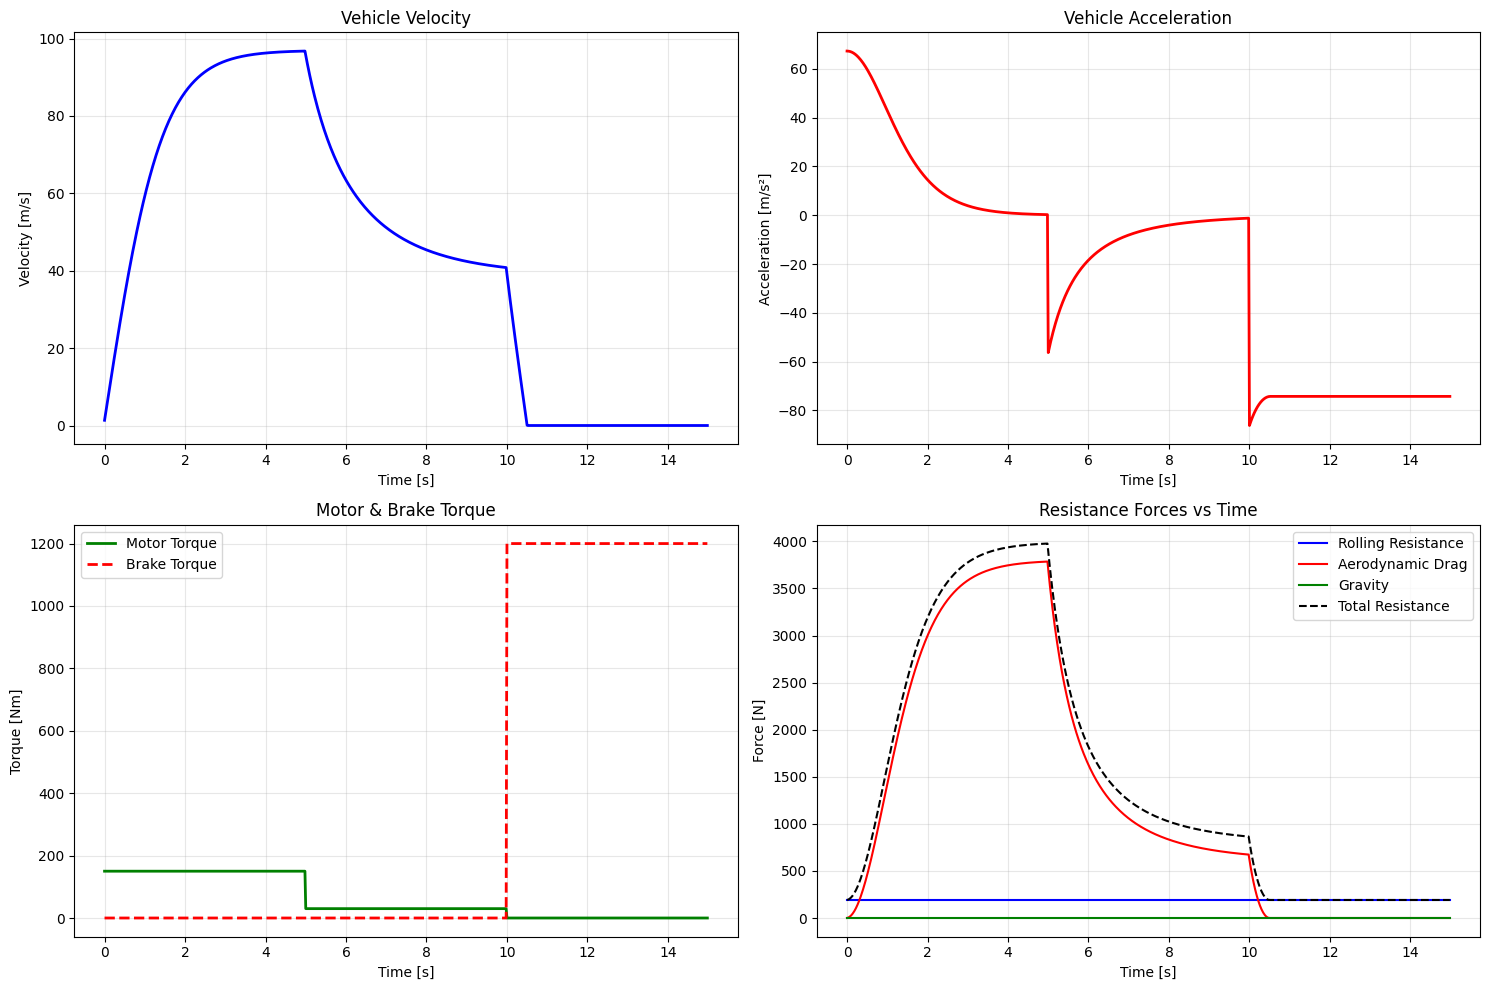

=== 종방향 동역학 테스트 결과 ===
최대 속도: 96.77 m/s
최대 가속도: 67.33 m/s²
최대 감속도: -86.23 m/s²
최대 모터 토크: 150 Nm
최대 브레이크 토크: 1200 Nm


In [31]:
# 종방향 모델 테스트 - 가속/브레이크 시나리오
def test_longitudinal_dynamics():
    # 시뮬레이션 파라미터
    dt = 0.02  # 시간 간격 [s]
    t_total = 15.0  # 총 시간 [s]
    time = np.arange(0, t_total, dt)
    
    # 초기 조건
    velocity = 0.0  # 초기 속도 [m/s]
    position = 0.0  # 초기 위치 [m]
    
    # 저장할 데이터
    velocities = []
    positions = []
    accelerations = []
    motor_torques = []
    brake_torques = []
    
    # 페달 입력 시나리오 (0~5초: 가속, 5~10초: 유지, 10~15초: 브레이크)
    for t in time:
        if t < 5.0:
            pedal_input = 0.5  # 50% 가속
        elif t < 10.0:
            pedal_input = 0.1  # 10% 유지
        else:
            pedal_input = -0.3  # 30% 브레이크
        
        # 토크 계산
        motor_torque, brake_torque = long_dynamics.pedal_to_torque(pedal_input) # TODO: long_dynamics를 사용하여여 모터 토크와 브레이크 토크 계산식 작성
        
        # 가속도 계산
        acceleration, _, F_roll, F_aero, F_grav = long_dynamics.motor_dynamics(motor_torque, brake_torque, velocity) # TODO: long_dynamics를 사용하여 가속도, 저항력 계산식 작성
        
        # 속도 업데이트 (Euler integration)
        velocity += acceleration * dt # TODO: 종가속도 계산식 작성
        velocity = max(0.0, velocity)  # 후진 방지
        position += velocity * dt # TODO: 종위치 계산식 작성
        
        # 데이터 저장
        velocities.append(velocity)
        positions.append(position)
        accelerations.append(acceleration)
        motor_torques.append(motor_torque)
        brake_torques.append(brake_torque)
    
    return time, velocities, positions, accelerations, motor_torques, brake_torques

# 테스트 실행
time_data, vel_data, pos_data, acc_data, motor_data, brake_data = test_longitudinal_dynamics()

# 결과 시각화
plt.figure(figsize=(15, 10))

# 속도 그래프
plt.subplot(2, 2, 1)
plt.plot(time_data, vel_data, 'b-', linewidth=2)
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Vehicle Velocity')
plt.grid(True, alpha=0.3)

# 가속도 그래프
plt.subplot(2, 2, 2)
plt.plot(time_data, acc_data, 'r-', linewidth=2)
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.title('Vehicle Acceleration')
plt.grid(True, alpha=0.3)

# 모터 토크 그래프
plt.subplot(2, 2, 3)
plt.plot(time_data, motor_data, 'g-', linewidth=2, label='Motor Torque')
plt.plot(time_data, brake_data, 'r--', linewidth=2, label='Brake Torque')
plt.xlabel('Time [s]')
plt.ylabel('Torque [Nm]')
plt.title('Motor & Brake Torque')
plt.legend()
plt.grid(True, alpha=0.3)

# 저항력 분석 (특정 속도에서)
velocities_range = np.linspace(0, 30, 100)
F_rolls, F_aeros, F_gravs = [], [], []
for v in vel_data:
    F_roll, F_aero, F_grav = long_dynamics.calculate_resistances(v)
    F_rolls.append(F_roll)
    F_aeros.append(F_aero)
    F_gravs.append(F_grav)

plt.subplot(2, 2, 4)
plt.plot(time_data, F_rolls, 'b-', label='Rolling Resistance')
plt.plot(time_data, F_aeros, 'r-', label='Aerodynamic Drag')
plt.plot(time_data, F_gravs, 'g-', label='Gravity')
plt.plot(time_data, np.array(F_rolls) + np.array(F_aeros) + np.array(F_gravs), 'k--', label='Total Resistance')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Resistance Forces vs Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== 종방향 동역학 테스트 결과 ===")
print(f"최대 속도: {max(vel_data):.2f} m/s")
print(f"최대 가속도: {max(acc_data):.2f} m/s²")
print(f"최대 감속도: {min(acc_data):.2f} m/s²")
print(f"최대 모터 토크: {max(motor_data):.0f} Nm")
print(f"최대 브레이크 토크: {max(brake_data):.0f} Nm")


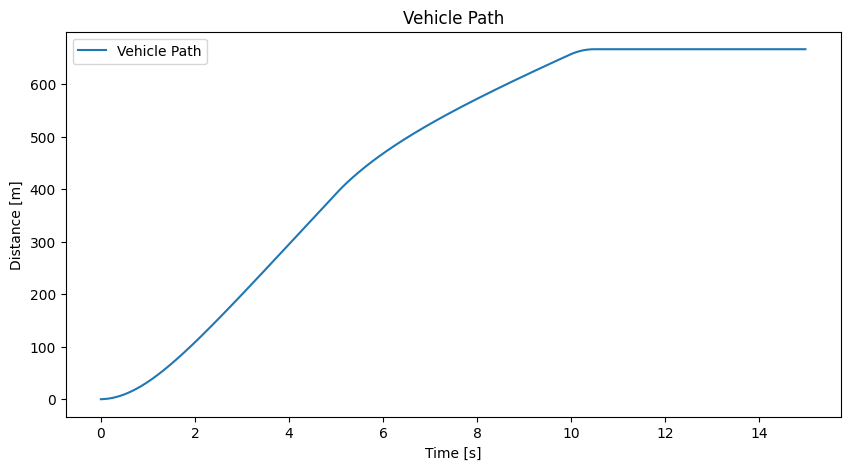

In [21]:
# 각 시간에서의 차량 위치 정보 시각화
plt.figure(figsize=(10, 5))
plt.plot(time_data, pos_data, label='Vehicle Path')
plt.xlabel('Time [s]')
plt.ylabel('Distance [m]')
plt.title('Vehicle Path')
plt.legend()
plt.show()

## 2. 횡방향 Kinematic & Dynamic 모델 (Lateral Kinematic & Dynamic Models)

횡방향 동역학은 차량의 좌우 방향 움직임을 모델링합니다. 속도에 따라 kinematic 모델과 dynamic 모델 중 하나를 선택적으로 사용합니다.

### 2.1 Kinematic 모델 (v < 5 m/s)

저속에서는 타이어의 슬립각이 작아 기하학적 관계만으로 모델링이 가능합니다.

<img src="../resources/ch9/lateral_kinematic_model.PNG" width="50%">

```
ψ̇ = V cos(β) / (l_f + l_r) * tan(δ_f)
Ẋ = V cos(ψ + β)
Ẏ = V sin(ψ + β)
β = arctan((l_r * tan(δ_f)) / (l_f + l_r))
```

### 2.2 Dynamic 모델 (v ≥ 5 m/s)

고속에서는 타이어의 측력과 슬립각을 고려한 동적 모델이 필요합니다.

<img src="../resources/ch9/lateral_dynamic_model.PNG" width="50%">

```
Ẋ = V_G cos(ψ + β)
Ẏ = V_G sin(ψ + β)
β̇ = (2C_αf)/(mV_x) * (δ - β - l_f*γ/V_x) + (2C_αr)/(mV_x) * (-β + l_r*γ/V_x) - γ
ψ̇ = γ
γ̇ = (2l_f*C_αf)/I_Z * (δ - β - l_f*γ/V_x) - (2l_r*C_αr)/I_Z * (-β + l_r*γ/V_x)
```

여기서:
- `β`: 슬립각 [rad]
- `γ (yaw rate)`: 요 각속도 [rad/s]
- `C_αf, C_αr`: 전후륜 코너링 강성 [N/rad]


In [22]:
# 횡방향 모델 인스턴스 생성
from tutlibs.vehicle_dynamics.custom_simviz import LateralDynamics
lat_dynamics = LateralDynamics() # TODO: 해당 클래스 빈칸 작성

print("=== 횡방향 동역학 모델 생성 완료 ===")
print(f"휠베이스: {lat_dynamics.L:.2f} m")
print(f"전축 거리: {lat_dynamics.Lf:.2f} m")
print(f"후축 거리: {lat_dynamics.Lr:.2f} m")
print(f"전륜 코너링 강성: {lat_dynamics.Cf:,.0f} N/rad")
print(f"후륜 코너링 강성: {lat_dynamics.Cr:,.0f} N/rad")
print(f"모델 스위칭 속도: {lat_dynamics.v_switch} m/s")


=== 횡방향 동역학 모델 생성 완료 ===
휠베이스: 2.70 m
전축 거리: 1.30 m
후축 거리: 1.40 m
전륜 코너링 강성: 160,000 N/rad
후륜 코너링 강성: 170,000 N/rad
모델 스위칭 속도: 5.0 m/s


=== 횡방향 모델 비교 테스트 (5, 10, 30 m/s) ===
조향각: 10도, 시뮬레이션 시간: 5초
- 5 m/s: Kinematic 모델 사용
- 10 m/s: Dynamic 모델 사용
- 30 m/s: Dynamic 모델 사용


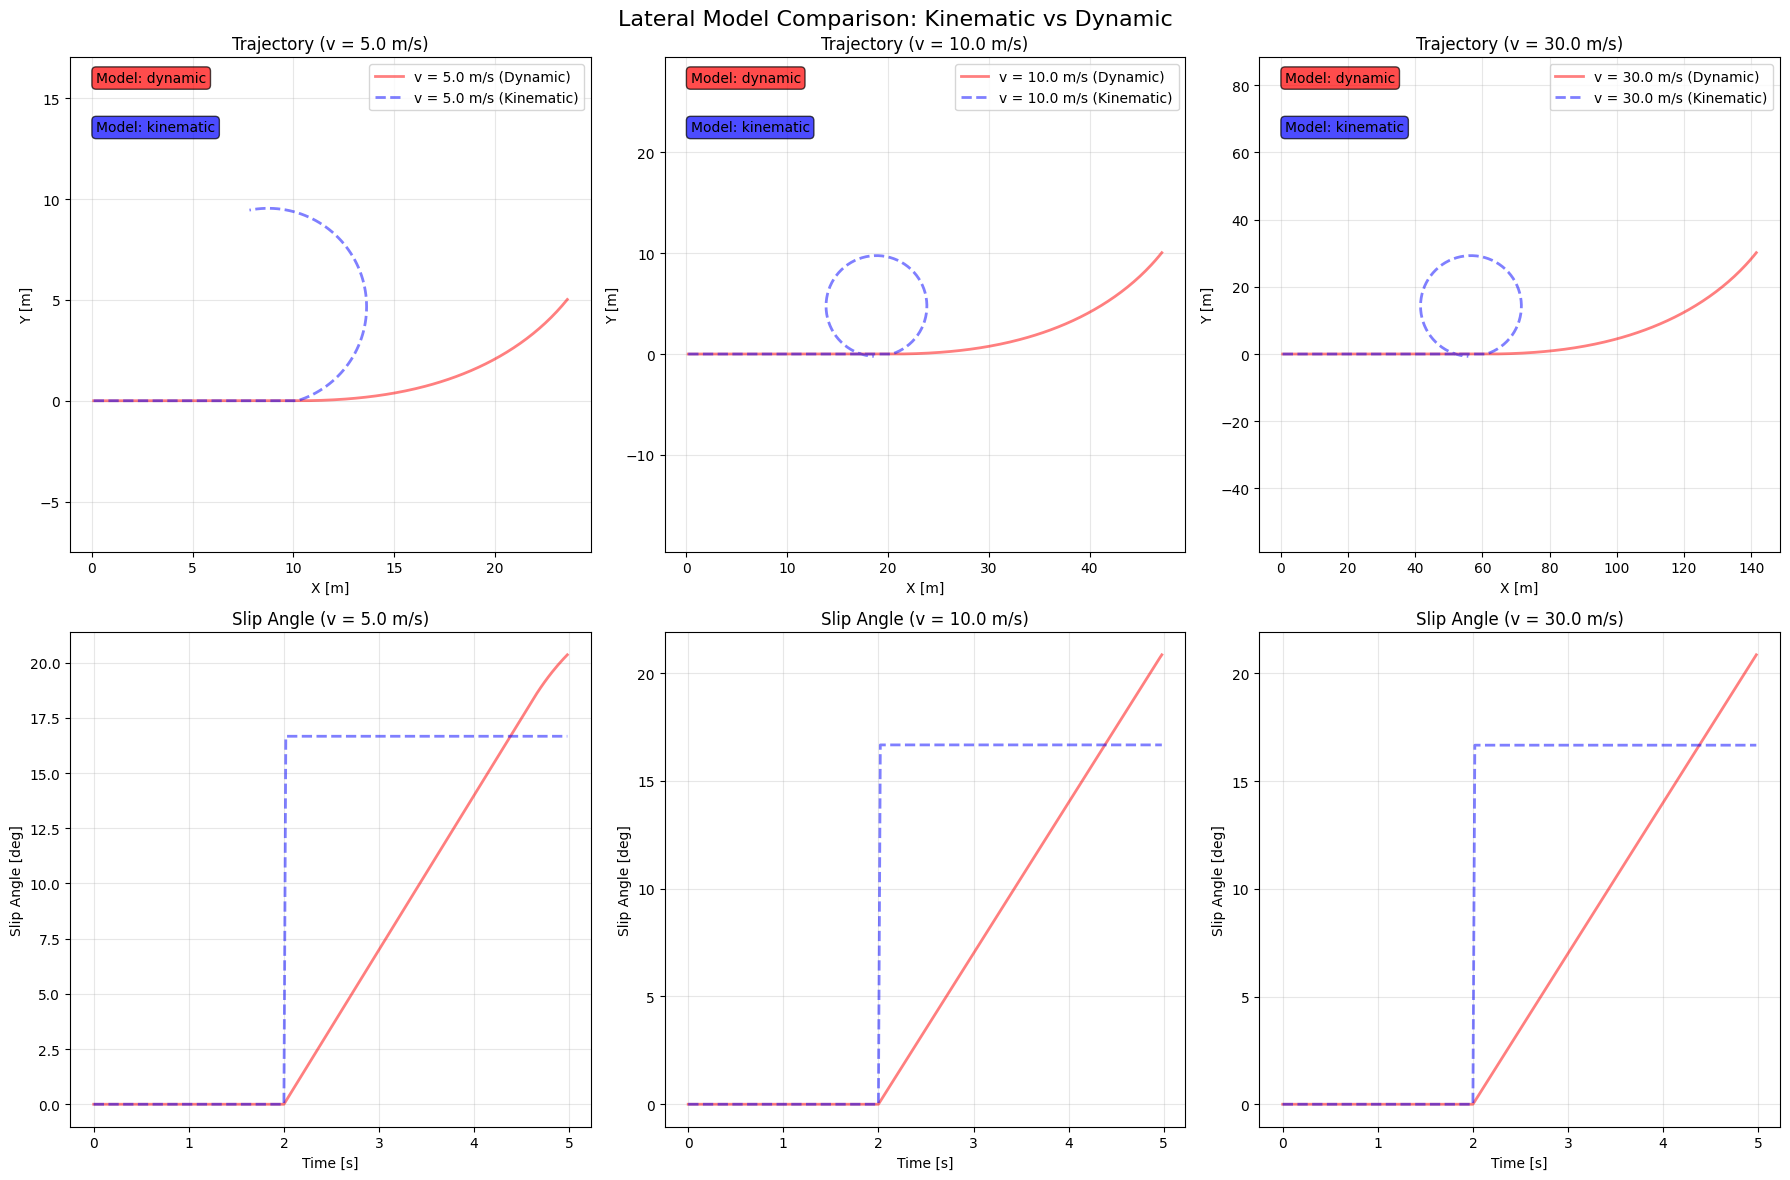

✓ 횡방향 모델 비교 완료

🔍 결과 분석:
- Kinematic 모델 (5 m/s): 기하학적 관계만 고려, 단순한 궤적
- Dynamic 모델 (10, 30 m/s): 타이어 슬립과 관성력 고려, 더 현실적인 응답
- 고속일수록 슬립각이 커지고 응답이 복잡해짐


In [23]:
# 횡방향 모델 비교 테스트 (5, 10, 30 m/s)
from tutlibs.vehicle_dynamics.custom_simviz import plot_lateral_model_comparison

print("=== 횡방향 모델 비교 테스트 (5, 10, 30 m/s) ===")
print("조향각: 10도, 시뮬레이션 시간: 5초")
print("- 5 m/s: Kinematic 모델 사용")
print("- 10 m/s: Dynamic 모델 사용") 
print("- 30 m/s: Dynamic 모델 사용")

# 속도별 횡방향 모델 비교 시각화
plot_lateral_model_comparison(
    lat_dynamics, 
    velocities=[5.0, 10.0, 30.0],
    steering_angle=np.deg2rad(30.0),
    duration=5.0,
    dt=0.02
)

print("✓ 횡방향 모델 비교 완료")
print("\n🔍 결과 분석:")
print("- Kinematic 모델 (5 m/s): 기하학적 관계만 고려, 단순한 궤적")
print("- Dynamic 모델 (10, 30 m/s): 타이어 슬립과 관성력 고려, 더 현실적인 응답")
print("- 고속일수록 슬립각이 커지고 응답이 복잡해짐")


## 3. 통합 차량 동역학 시뮬레이션

종방향과 횡방향 동역학을 결합하여 실제 주행과 유사한 시뮬레이션을 수행합니다. 가속/브레이크와 조향 입력을 동시에 적용하여 차량의 복합적인 움직임을 관찰할 수 있습니다.


=== 통합 차량 동역학 시뮬레이션 시작 ===
시뮬레이션 시간: 20초
시간 간격: 0.02초
총 스텝 수: 1000개
✓ 시뮬레이션 완료
최종 위치: (677.71, 168.51) m
최대 속도: 81.11 m/s
최대 슬립각: 9.50°


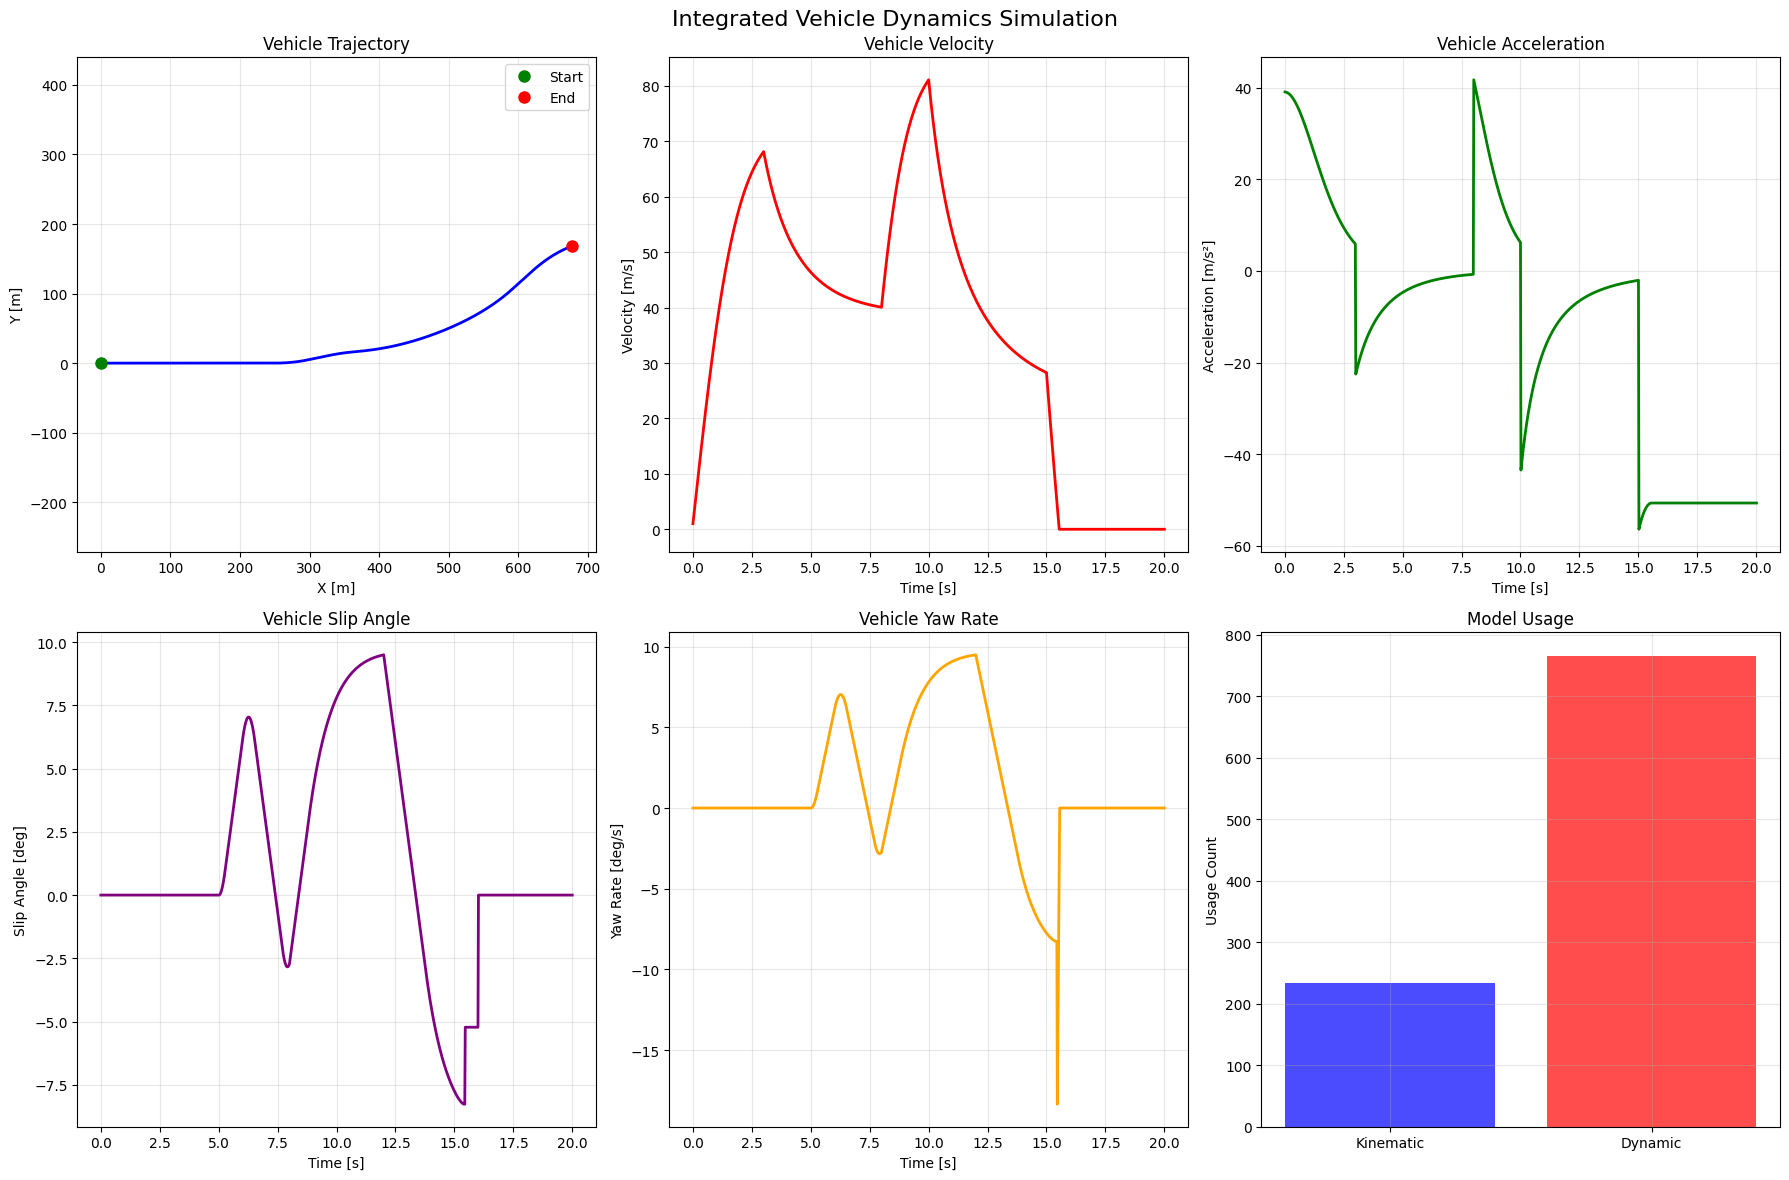

In [24]:
# 통합 차량 동역학 시뮬레이션
from tutlibs.vehicle_dynamics.custom_simviz import VehicleDynamicsSimulator, VehicleState, plot_vehicle_trajectory

# 시뮬레이터 생성
simulator = VehicleDynamicsSimulator(long_dynamics, lat_dynamics) # TODO: 종방향 동역학 모델과 횡방향 동역학 모델 생성

def create_driving_scenario():
    """실제 주행과 유사한 시나리오 생성"""
    dt = 0.02
    duration = 20.0  # 20초 시뮬레이션
    time_steps = int(duration / dt)
    
    pedal_inputs = []
    steering_inputs = []
    
    for i in range(time_steps):
        t = i * dt
        
        # 페달 입력 시나리오
        if t < 3.0:
            pedal = 0.3  # 초기 가속
        elif t < 8.0:
            pedal = 0.1  # 등속 주행
        elif t < 10.0:
            pedal = 0.4  # 추가 가속
        elif t < 15.0:
            pedal = 0.05  # 유지
        else:
            pedal = -0.2  # 감속
        
        # 조향 입력 시나리오 (S자 커브)
        if t < 5.0:
            steering = 0.0  # 직진
        elif t < 8.0:
            steering = np.deg2rad(15.0) * np.sin(2 * np.pi * (t-5) / 3)  # 좌우 조향
        elif t < 12.0:
            steering = np.deg2rad(10.0)  # 우회전
        elif t < 16.0:
            steering = np.deg2rad(-10.0)  # 좌회전
        else:
            steering = 0.0  # 직진
        
        pedal_inputs.append(pedal)
        steering_inputs.append(steering)
    
    return pedal_inputs, steering_inputs

# 주행 시나리오 생성
pedal_scenario, steering_scenario = create_driving_scenario()

# 초기 상태 설정
initial_state = VehicleState(
    x=0.0, y=0.0, yaw=0.0,
    velocity=1.0,  # 초기 속도 1 m/s
    beta=0.0, yaw_rate=0.0
)

print("=== 통합 차량 동역학 시뮬레이션 시작 ===")
print(f"시뮬레이션 시간: 20초")
print(f"시간 간격: 0.02초")
print(f"총 스텝 수: {len(pedal_scenario)}개")

# 시뮬레이션 실행
states, sim_infos = simulator.simulate_trajectory(
    initial_state, pedal_scenario, steering_scenario, dt=0.02) # TODO: 시뮬레이션 실행 함수 완성

print("✓ 시뮬레이션 완료")
print(f"최종 위치: ({states[-1].x:.2f}, {states[-1].y:.2f}) m")
print(f"최대 속도: {max(s.velocity for s in states):.2f} m/s")
print(f"최대 슬립각: {max(abs(s.beta) for s in states) * 180/np.pi:.2f}°")

# 결과 시각화
plot_vehicle_trajectory(states, sim_infos, "Integrated Vehicle Dynamics Simulation")


## 4. 종횡방향 제어 알고리즘

실제 자율주행에서 사용되는 제어 알고리즘을 구현하고 테스트합니다.

### 4.1 횡방향 제어
- **Pure Pursuit**: Lookahead 포인트를 추종하는 기하학적 제어
- **(Optional) Stanley**: 크로스 트랙 에러와 헤딩 에러를 동시에 보정하는 제어

### 4.2 종방향 제어  
- **PID 제어**: 목표 속도 추종을 위한 비례-적분-미분 제어
- **적응형 속도 제어**: 경로 곡률에 따른 속도 조절


In [26]:
# 제어 알고리즘 테스트
from tutlibs.vehicle_dynamics.custom_lat_pure_pursuit import PurePursuitController
from tutlibs.vehicle_dynamics.custom_long_pid import PIDController, AdaptiveSpeedController

print("=== 제어 알고리즘 개별 테스트 ===")

# Pure Pursuit 제어기 테스트
print("\n1. Pure Pursuit 제어기 테스트")
pp_controller = PurePursuitController(wheelbase=2.7, lookahead_base=5.0, lookahead_gain=0.3) # TODO: Pure Pursuit 제어기 생성

# 테스트 경로 (원형)
theta = np.linspace(0, 2*np.pi, 100)
radius = 30.0
path_x = radius * np.cos(theta)
path_y = radius * np.sin(theta)

# 차량 상태
vehicle_x, vehicle_y = 20.0, 0.0
vehicle_yaw = np.pi/6
vehicle_velocity = 12.0

steering_pp, info_pp = pp_controller.pure_pursuit_control(
    vehicle_x, vehicle_y, vehicle_yaw, vehicle_velocity, path_x, path_y) # TODO: 횡방향 제어 함수 완성

print(f"Pure Pursuit 조향각: {np.rad2deg(steering_pp):.2f}°")
print(f"룩어헤드 거리: {info_pp['lookahead_distance']:.2f} m")
print(f"횡방향 오차: {info_pp['lateral_error']:.2f} m")

# PID 제어기 테스트
print("\n2. PID 제어기 테스트")
pid_controller = PIDController(kp=1.0, ki=1.0, kd=1.0) # TODO: PID 제어기 생성 - 파라미터 조정

target_speed = 7.0
current_speed = 10.0
pedal_output, info_pid = pid_controller.update(target_speed, current_speed) # TODO: 종방향 제어 함수 완성

print(f"목표 속도: {target_speed:.1f} m/s")
print(f"현재 속도: {current_speed:.1f} m/s")
print(f"속도 오차: {info_pid['error']:.2f} m/s")
print(f"PID 출력: {pedal_output:.3f}")

print("\n✓ 모든 제어 알고리즘 테스트 완료")

=== 제어 알고리즘 개별 테스트 ===

1. Pure Pursuit 제어기 테스트
Pure Pursuit 조향각: -15.11°
룩어헤드 거리: 8.60 m
횡방향 오차: -5.00 m

2. PID 제어기 테스트
목표 속도: 7.0 m/s
현재 속도: 10.0 m/s
속도 오차: -3.00 m/s
PID 출력: -1.000

✓ 모든 제어 알고리즘 테스트 완료


## 5. 통합 경로 추종 시뮬레이션

차량 동역학 모델과 제어 알고리즘을 결합하여 실제 경로 추종 시뮬레이션을 수행합니다. (Optional) 기존 CSV 경로 파일을 사용하여 Pure Pursuit과 Stanley 제어기의 성능을 비교분석합니다.


=== 경로 추종 시뮬레이션 ===
경로 포인트 수: 1292개
경로 범위: X(-484.4~-290.7), Y(-9.7~142.4)


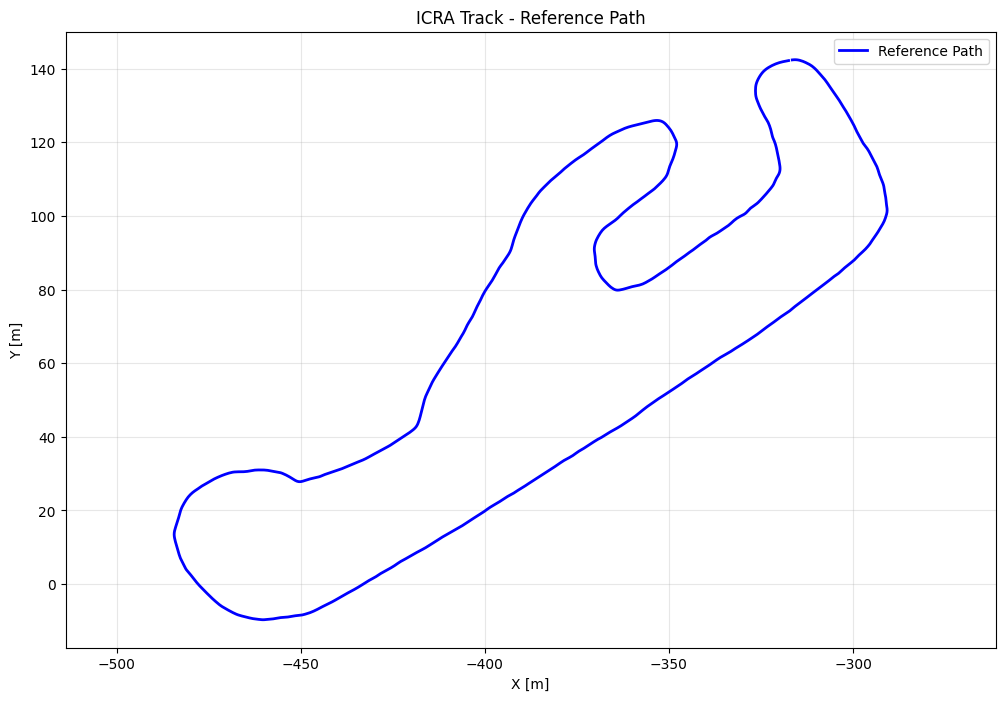

✓ 경로 추종 시뮬레이터 준비 완료


In [27]:
# 경로 데이터 로드
def load_path_csv(csv_path):
    """CSV 경로 파일 로드"""
    try:
        data = np.loadtxt(csv_path, delimiter=',', skiprows=1)
        return data[:, 0], data[:, 1]  # x, y 좌표
    except:
        data = np.loadtxt(csv_path, delimiter=',')
        return data[:, 0], data[:, 1]

# ICRA 경로 로드
path_x, path_y = load_path_csv("./../data/control_trajectory/racetrack_centerline.csv")
# path_x, path_y = load_path_csv("./../data/control_trajectory/path_straight.csv")
# path_x, path_y = load_path_csv("./../data/control_trajectory/path_circle.csv")

print("=== 경로 추종 시뮬레이션 ===")
print(f"경로 포인트 수: {len(path_x)}개")
print(f"경로 범위: X({np.min(path_x):.1f}~{np.max(path_x):.1f}), Y({np.min(path_y):.1f}~{np.max(path_y):.1f})")

# 경로 시각화
plt.figure(figsize=(12, 8))
plt.plot(path_x, path_y, 'b-', linewidth=2, label='Reference Path')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('ICRA Track - Reference Path')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.legend()
plt.show()

# 통합 경로 추종 시뮬레이터 클래스
class PathFollowingSimulator:
    def __init__(self, vehicle_dynamics, lateral_controller, longitudinal_controller):
        self.vehicle_dynamics = vehicle_dynamics
        self.lateral_controller = lateral_controller
        self.longitudinal_controller = longitudinal_controller
        self.speed_controller = AdaptiveSpeedController(base_speed=12.0, curvature_factor=30.0) # TODO: 적응형 속도 제어기 생성
        
    def find_closest_path_index(self, vehicle_x, vehicle_y, path_x, path_y):
        """가장 가까운 경로 인덱스 찾기"""
        distances = np.sqrt((path_x-vehicle_x)**2 + (path_y-vehicle_y)**2 ) # TODO: 거리 계산식 작성
        return np.argmin(distances)
    
    def simulate_path_following(self, path_x, path_y, initial_state, duration=30.0, dt=0.02):
        """경로 추종 시뮬레이션"""
        time_steps = int(duration / dt)
        states = [initial_state]
        control_infos = []
        
        current_state = initial_state
        self.longitudinal_controller.reset()  # PID 초기화
        
        for step in range(time_steps):
            # 현재 위치에서 가장 가까운 경로점 찾기
            closest_idx = self.find_closest_path_index(
                current_state.x, current_state.y, path_x, path_y) # TODO: 가장 가까운 경로점 찾기
            
            # 목표 속도 계산 (곡률 기반)
            target_speed = self.speed_controller.get_target_speed(path_x, path_y, closest_idx) # TODO: 목표 속도 계산식 작성
            
            # 횡방향 제어 (조향각 계산)
            if isinstance(self.lateral_controller, PurePursuitController):
                steering_angle, lat_info = self.lateral_controller.pure_pursuit_control(
                    current_state.x, current_state.y, current_state.yaw, 
                    current_state.velocity, path_x, path_y) # TODO: Pure Pursuit 제어 계산식 작성
            else:
                steering_angle, lat_info = 0.0, {}
            
            # 종방향 제어 (페달 입력 계산)
            pedal_input, long_info = self.longitudinal_controller.update(
                target_speed, current_state.velocity) # TODO: 종방향 제어 함수 완성
            
            # 차량 동역학 시뮬레이션
            new_state, sim_info = self.vehicle_dynamics.simulate_step(
                current_state, pedal_input, steering_angle, dt) # TODO: 차량 동역학 시뮬레이션 함수 완성
            
            # 경로 이탈 체크 (너무 멀리 벗어나면 시뮬레이션 종료)
            closest_distance = np.sqrt((new_state.x - path_x[closest_idx])**2 + 
                                     (new_state.y - path_y[closest_idx])**2)
            if closest_distance > 20.0:  # 20m 이상 벗어나면 종료
                print(f"경로 이탈로 시뮬레이션 종료 (step: {step}, distance: {closest_distance:.1f}m)")
                break
            
            # 상태 업데이트
            current_state = new_state
            states.append(current_state)
            
            # 제어 정보 저장
            control_info = {
                'closest_idx': closest_idx,
                'target_speed': target_speed,
                'lateral_info': lat_info,
                'longitudinal_info': long_info,
                'steering_angle': steering_angle,
                'pedal_input': pedal_input
            }
            control_infos.append(control_info)
            
            # 목표점 근처 도달 시 종료
            if closest_idx >= len(path_x) - 10:
                print(f"목표점 도달로 시뮬레이션 종료 (step: {step})")
                break
        
        return states, control_infos

print("✓ 경로 추종 시뮬레이터 준비 완료")


=== Pure Pursuit 제어기 결과 ===

Pure Pursuit 제어기 시뮬레이션 실행 중...
Pure Pursuit 완료: 2001개 스텝


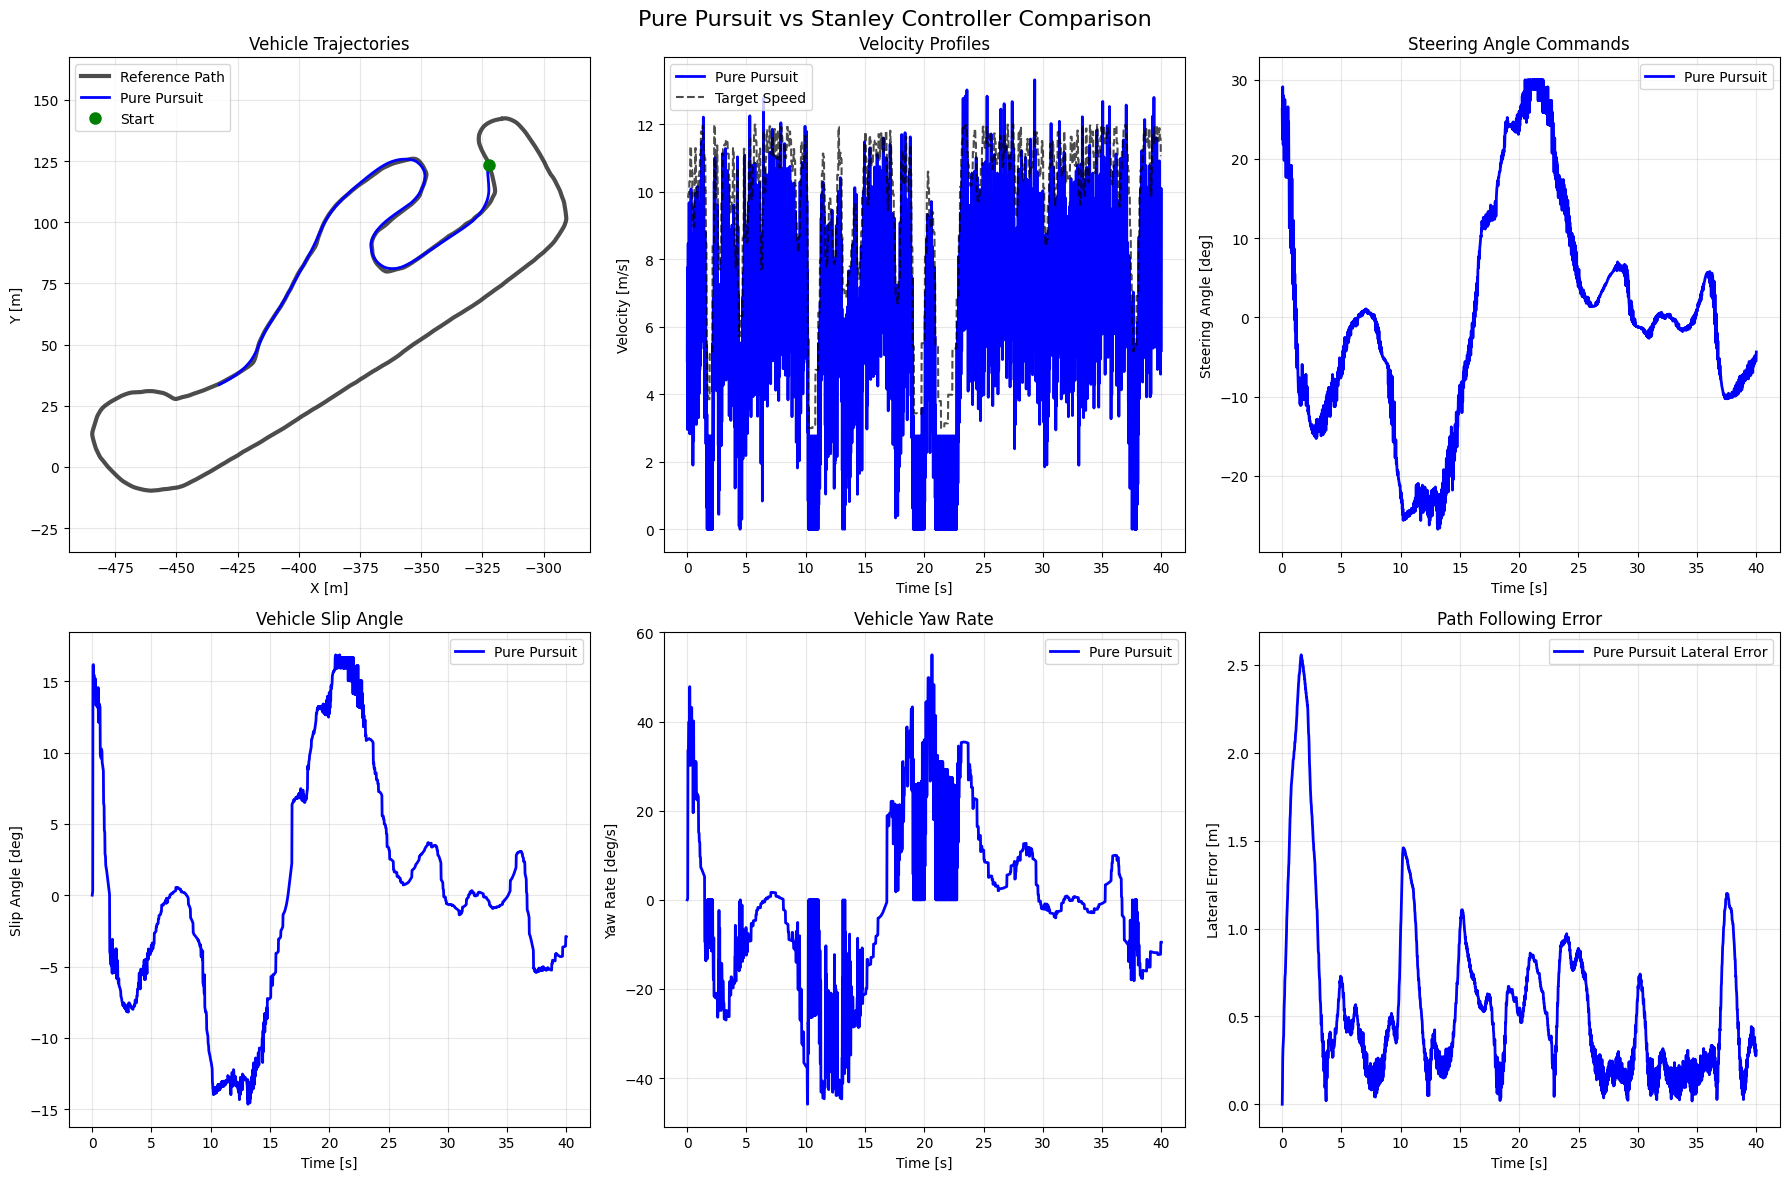


=== 성능 비교 결과 ===
지표                   Pure Pursuit   
--------------------------------------------------
완주 시간 [s]            40.00          
평균 속도 [m/s]          6.27           
최대 속도 [m/s]          13.32          
평균 횡방향 오차 [m]        0.557          
최대 횡방향 오차 [m]        2.558          
평균 슬립각 [deg]         5.93           


In [30]:
# Pure Pursuit 제어기 결과 시뮬레이션
print("=== Pure Pursuit 제어기 결과 ===")

# 초기 상태 설정
initial_state = VehicleState(
    x=path_x[-50], y=path_y[-50], yaw=-120 * np.pi / 180,
    velocity=5.0, beta=0.0, yaw_rate=0.0
)

# Pure Pursuit 시뮬레이션
print("\nPure Pursuit 제어기 시뮬레이션 실행 중...")
pp_controller = PurePursuitController(wheelbase=lat_dynamics.L, lookahead_base=6.0, lookahead_gain=0.4)
pid_controller_pp = PIDController(kp=2.0, ki=0.1, kd=0.05)
simulator_pp = PathFollowingSimulator(simulator, pp_controller, pid_controller_pp)

states_pp, infos_pp = simulator_pp.simulate_path_following(
    path_x, path_y, initial_state, duration=40.0, dt=0.02)

print(f"Pure Pursuit 완료: {len(states_pp)}개 스텝")

# 결과 시각화
def plot_comparison_results(path_x, path_y, states_pp, infos_pp):
    """두 제어기 결과 비교 시각화"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Pure Pursuit vs Stanley Controller Comparison', fontsize=16)
    
    # 궤적 비교
    axes[0, 0].plot(path_x, path_y, 'k-', linewidth=3, alpha=0.7, label='Reference Path')
    axes[0, 0].plot([s.x for s in states_pp], [s.y for s in states_pp], 
                   'b-', linewidth=2, label='Pure Pursuit')
    axes[0, 0].plot(states_pp[0].x, states_pp[0].y, 'go', markersize=8, label='Start')
    axes[0, 0].set_xlabel('X [m]')
    axes[0, 0].set_ylabel('Y [m]')
    axes[0, 0].set_title('Vehicle Trajectories')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axis('equal')
    axes[0, 0].legend()
    
    # 속도 비교
    time_pp = np.arange(len(states_pp)) * 0.02
    
    axes[0, 1].plot(time_pp, [s.velocity for s in states_pp], 'b-', linewidth=2, label='Pure Pursuit')
    if infos_pp:
        axes[0, 1].plot(time_pp[1:], [info['target_speed'] for info in infos_pp], 
                       'k--', alpha=0.7, label='Target Speed')
    axes[0, 1].set_xlabel('Time [s]')
    axes[0, 1].set_ylabel('Velocity [m/s]')
    axes[0, 1].set_title('Velocity Profiles')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # 조향각 비교
    if infos_pp:
        axes[0, 2].plot(time_pp[1:], [np.rad2deg(info['steering_angle']) for info in infos_pp], 
                       'b-', linewidth=2, label='Pure Pursuit')
        axes[0, 2].set_xlabel('Time [s]')
        axes[0, 2].set_ylabel('Steering Angle [deg]')
        axes[0, 2].set_title('Steering Angle Commands')
        axes[0, 2].grid(True, alpha=0.3)
        axes[0, 2].legend()
    
    # 슬립각 비교
    axes[1, 0].plot(time_pp, [np.rad2deg(s.beta) for s in states_pp], 'b-', linewidth=2, label='Pure Pursuit')
    axes[1, 0].set_xlabel('Time [s]')
    axes[1, 0].set_ylabel('Slip Angle [deg]')
    axes[1, 0].set_title('Vehicle Slip Angle')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # 요 각속도 비교
    axes[1, 1].plot(time_pp, [np.rad2deg(s.yaw_rate) for s in states_pp], 'b-', linewidth=2, label='Pure Pursuit')
    axes[1, 1].set_xlabel('Time [s]')
    axes[1, 1].set_ylabel('Yaw Rate [deg/s]')
    axes[1, 1].set_title('Vehicle Yaw Rate')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
    
    # 횡방향 오차 비교 (경로와의 거리)
    def calculate_lateral_errors(states, path_x, path_y):
        errors = []
        for state in states:
            distances = np.sqrt((path_x - state.x)**2 + (path_y - state.y)**2)
            errors.append(np.min(distances))
        return errors
    
    # 크로스 트랙 에러 계산
    def calculate_path_yaw(path_x, path_y, closest_idx):
        """경로의 요 각도 계산"""
        if closest_idx < len(path_x) - 1:
            # 현재 점과 다음 점으로 경로 방향 계산
            dx = path_x[closest_idx + 1] - path_x[closest_idx]
            dy = path_y[closest_idx + 1] - path_y[closest_idx]
            path_yaw = np.arctan2(dy, dx)
        elif closest_idx > 0:
            # 마지막 점인 경우 이전 점과 현재 점으로 계산
            dx = path_x[closest_idx] - path_x[closest_idx - 1]
            dy = path_y[closest_idx] - path_y[closest_idx - 1]
            path_yaw = np.arctan2(dy, dx)
        else:
            # 단일 점인 경우
            path_yaw = 0.0
            
        return path_yaw

    def calculate_cross_track_error(states, path_x, path_y):
        """크로스 트랙 에러 계산 (부호 포함)"""
        # 가장 가까운 경로점에서 차량으로의 벡터
        errors = []
        for state in states:
            xxxxxx # TODO: 크로스 트랙 에러 계산식 작성
        return errors
    
    errors_pp = calculate_lateral_errors(states_pp, path_x, path_y)
    
    axes[1, 2].plot(time_pp, errors_pp, 'b-', linewidth=2, label='Pure Pursuit Lateral Error')
    axes[1, 2].set_xlabel('Time [s]')
    axes[1, 2].set_ylabel('Lateral Error [m]')
    axes[1, 2].set_title('Path Following Error')
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 성능 지표 계산
    print("\n=== 성능 비교 결과 ===")
    print(f"{'지표':<20} {'Pure Pursuit':<15}")
    print("-" * 50)
    print(f"{'완주 시간 [s]':<20} {time_pp[-1]:<15.2f}")
    print(f"{'평균 속도 [m/s]':<20} {np.mean([s.velocity for s in states_pp]):<15.2f}")
    print(f"{'최대 속도 [m/s]':<20} {max(s.velocity for s in states_pp):<15.2f}")
    print(f"{'평균 횡방향 오차 [m]':<20} {np.mean(errors_pp):<15.3f}")
    print(f"{'최대 횡방향 오차 [m]':<20} {max(errors_pp):<15.3f}")
    print(f"{'평균 슬립각 [deg]':<20} {np.mean([abs(s.beta) for s in states_pp])*180/np.pi:<15.2f}")

# 결과 시각화
plot_comparison_results(path_x, path_y, states_pp, infos_pp)


아래의 명령어를 터미널에 입력하여 실시간으로 통합 경로 추종 시스템을 확인할 수 있습니다.

In [ ]:
$ conda activate adas_practice
$ python practice/tutlibs/vehicle_dynamics/main_path_following_simulator.py

## 실습 요약 및 결론

### 🎯 실습에서 진행한 내용

1. **차량 동역학 모델링**
   - **종방향 Dynamic 모델**: 모터 토크, 공기저항, 구름저항을 고려한 1차원 동역학
   - **횡방향 Kinematic 모델**: 저속(v < 5m/s)에서 기하학적 관계 기반 모델
   - **횡방향 Dynamic 모델**: 고속(v ≥ 5m/s)에서 타이어 슬립각과 측력 고려

2. **제어 알고리즘 구현**
   - **Pure Pursuit**: 룩어헤드 포인트 기반 기하학적 제어
   - **PID 제어**: 종방향 속도 제어, 곡률 기반 적응형 속도 조절

3. **통합 시뮬레이션**
   - 종횡방향 동역학과 제어 알고리즘의 실시간 결합
   - 실제 경로 데이터를 활용한 경로 추종 성능 검증
   - 제어기별 특성 비교 및 성능 분석
